# Breast Cancer Cell Detection

Data Challenge 2020-07-02
Candidate: Isaac Chung
Time alloted: 3 hours

Task: to develop a model that predicts whether a biopsied breast cell is benign (not harmful) or malignant (cancerous), given a set of attributes about the cell.

## 0. Import data
First let's import the data set, and see what's inside. Data is given in a csv file. Let's use pandas' read_csv function.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import shapiro
from scipy.stats import skew
from scipy.stats import kurtosis
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
col_names = ['sample_id','clump_thickness','uc_size','uc_shape','marginal_adhesion','single_epithelial','bare_nuclei','bland_chromatin','normal_nucleoli','mitoses','class']
df = pd.read_csv('breast-cancer-wisconsin.csv', header=None, names=col_names)

## 1. Initial Data Analysis:
1. Data set shape, types
2. NaN values
3. Duplicates

In [3]:
def initial_analysis(df):
    """
    Given a dataframe produces a simple report on initial data analytics
    Params:
        - df 
    Returns:
        - Shape of dataframe records and columns
        - Columns and data types
    """
    print('Report of Initial Data Analysis:\n')
    print(f'Shape of dataframe: {df.shape}')
    print(f'Features and Data Types: \n {df.dtypes}')

### 1.1 Shape and types
We have 699 rows and 11 features. All but one features are integers. 

In [4]:
initial_analysis(df)

Report of Initial Data Analysis:

Shape of dataframe: (699, 11)
Features and Data Types: 
 sample_id             int64
clump_thickness       int64
uc_size               int64
uc_shape              int64
marginal_adhesion     int64
single_epithelial     int64
bare_nuclei          object
bland_chromatin       int64
normal_nucleoli       int64
mitoses               int64
class                 int64
dtype: object


Let's check out the first 5 rows of the data, and see a brief summary.

In [5]:
df.head()

,sample_id,clump_thickness,uc_size,uc_shape,marginal_adhesion,single_epithelial,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


### 1.2 NaN values

We see that the first column is the sample id, columns 2-10 are cell features, and the last column is the class (2 for benign, 4 for malignant).
Upon inspection of the column 'bare_nuclei', it seems that there's something that is not 'NaN' that's causing it to be read as object type.

In [6]:
df.describe()

,sample_id,clump_thickness,uc_size,uc_shape,marginal_adhesion,single_epithelial,bland_chromatin,normal_nucleoli,mitoses,class
count,6.990000e+02,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,1.071704e+06,4.417740,3.134478,3.207439,2.806867,3.216023,3.437768,2.866953,1.589413,2.689557
std,6.170957e+05,2.815741,3.051459,2.971913,2.855379,2.214300,2.438364,3.053634,1.715078,0.951273
min,6.163400e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,8.706885e+05,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000
50%,1.171710e+06,4.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,2.000000
75%,1.238298e+06,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,1.000000,4.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


In [7]:
df['bare_nuclei'] = pd.to_numeric(df['bare_nuclei'], errors='coerce', downcast='integer')

In [8]:
df['bare_nuclei'].isna().sum()

16

Converting the column to integers returns some 'NaN' values. 16 rows have this. Since it takes up only 2.3% of the data, we temporarily drop these rows. 

In [9]:
df = df.dropna()

### 1.3 Duplicates
We also check for duplicated rows. Using all columns to check for duplicates, 8 rows are returned. Let's see what these rows are.

In [10]:
df.duplicated().sum()

8

We see that none of these rows are actually duplicates. Thus, nothing is removed. 

In [11]:
df[df.duplicated()]

,sample_id,clump_thickness,uc_size,uc_shape,marginal_adhesion,single_epithelial,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
208,1218860,1,1,1,1,1,1.0,3,1,1,2
253,1100524,6,10,10,2,8,10.0,7,3,3,4
254,1116116,9,10,10,1,10,8.0,3,3,1,4
258,1198641,3,1,1,1,2,1.0,3,1,1,2
272,320675,3,3,5,2,3,10.0,7,1,1,4
338,704097,1,1,1,1,1,1.0,2,1,1,2
561,1321942,5,1,1,1,2,1.0,3,1,1,2
684,466906,1,1,1,1,2,1.0,1,1,1,2


In [12]:
df.describe()

,sample_id,clump_thickness,uc_size,uc_shape,marginal_adhesion,single_epithelial,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
count,6.830000e+02,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000
mean,1.076720e+06,4.442167,3.150805,3.215227,2.830161,3.234261,3.544656,3.445095,2.869693,1.603221,2.699854
std,6.206440e+05,2.820761,3.065145,2.988581,2.864562,2.223085,3.643857,2.449697,3.052666,1.732674,0.954592
min,6.337500e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,8.776170e+05,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000
50%,1.171795e+06,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000
75%,1.238705e+06,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000,4.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


## 2. Data cleaning / formatting

As the 1st column is sample id, we can drop that from our analysis.
We can also separate the feature columns and target column for convenience.

In [13]:
df = df.drop(columns=['sample_id'])

In [14]:
features = df.drop(columns=['class'])
targets = df['class']

## 3. Exploratory Data Analysis

Next, let's visualize the distributions of the features. Before that, we want to check if any of the features are Normal.

In [15]:
def normality_test(df,col_list):
    """
    Given a dataframe determines whether each numerical column is Gaussian 
    Ho = Assumes distribution is Gaussian
    Ha = Assumes distribution is not Gaussian
    Params:
        - df
    Returns:
        - W Statistic
        - p-value
        - List of columns that do not have gaussian distribution
    """
    non_gauss=[]
    w_stat=[]
    # Determine if each sample of numerical feature is gaussian
    alpha = 0.05
    for n in col_list:
        stat,p=shapiro(df[n])
#         print(sns.distplot(df[n]))
#         print(skew(df[n]),kurtosis(df[n]))

        if p <= alpha: # Reject Ho -- Distribution is not normal
            non_gauss.append(n)
            w_stat.append(stat)
    # Dictionary of numerical features not gaussian and W-Statistic        
    norm_dict=dict(zip(non_gauss,w_stat))
    return norm_dict

The Shapiro-Wilk test is a way to tell if a random sample comes from a normal distribution. The test gives you a W value; small values indicate your sample is not normally distributed. 

Here we see that all of the features have high w-values, thus we fail to reject the null hypothesis (feature distribution is a Normal distribution) for all features. 

In [16]:
normality_test(features,features.columns.values)

{'clump_thickness': 0.9026244878768921,
 'uc_size': 0.7158083915710449,
 'uc_shape': 0.745498538017273,
 'marginal_adhesion': 0.6768060922622681,
 'single_epithelial': 0.7188340425491333,
 'bare_nuclei': 0.669580340385437,
 'bland_chromatin': 0.8365986347198486,
 'normal_nucleoli': 0.6481487154960632,
 'mitoses': 0.3983740210533142}

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E6218BB208>,
      dtype=object)

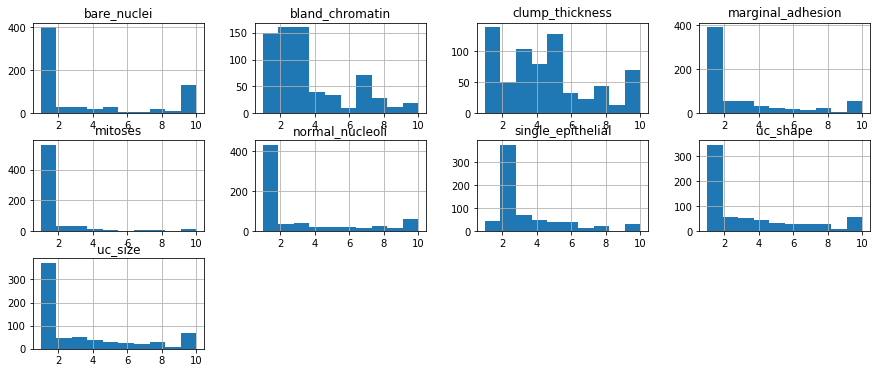

In [17]:
features.hist(bins=10, figsize=(15,6), layout=(3,4))

The boxplot can help us visualize potential outliers in each of the features.

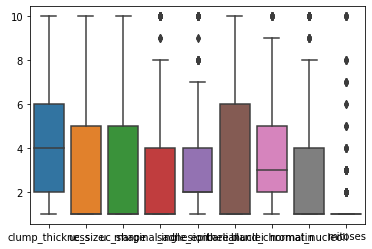

In [18]:
sns.boxplot(data=features)

We can show the correlation between features on a seaborn heatmap.

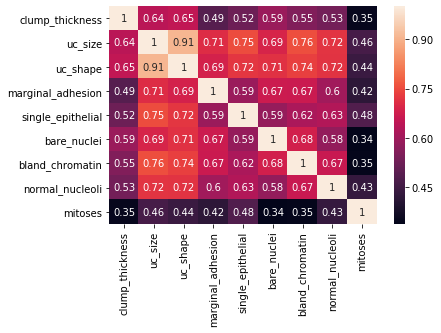

In [19]:
sns.heatmap(features.corr(), annot=True)

## 4. Classification

The goal here is to predict whether a biopsied breast cell is benign (not harmful) or malignant (cancerous), given a set of attributes about the cell. 

### 4.1 Logistic Regression
We can first use a simple logistic regression model. Let's use the sklearn. Here we first use all of the raw features, and split the train-test set with the default 75-25 way. 

**Note 1**: Since we are dealing with cancer prognosis, it is important that we not only evaluate the accuracy of the model, but also the recall (True positive/(True positive + False negative)). We want to capture all cells that are truly cancerous, and prevent mis-predicting them as non-cancerous.

**Note 2**: Also, since the classes are imbalanced in the test set, the f1 score should be a better model evaluation metric than accuracy.

In [22]:
def class_report(y_test, y_pred):
    # sklearn classification report
    print(classification_report(y_test,y_pred))
    
    # sklearn confusion matrix in seaborn heatmap
    ax= plt.subplot()
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, ax=ax)
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['benign', 'malignant']); ax.yaxis.set_ticklabels(['benign', 'malignant']);

We see that even though we have a average f1 score of 94%, the recall for malignant is at 88%

              precision    recall  f1-score   support

           2       0.93      0.99      0.96       103
           4       0.98      0.88      0.93        68

    accuracy                           0.95       171
   macro avg       0.96      0.94      0.94       171
weighted avg       0.95      0.95      0.95       171



C:\test\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


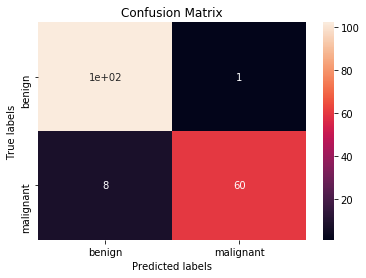

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(features, targets, random_state=42)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
class_report(y_test,y_pred)

The features are rangng from 1-10. Here we scale the features to have zero mean and unit variance. 

Here we see that the recall on maglinant cells (class 4) has improved from 88% to 90% by scaling our features.

              precision    recall  f1-score   support

           2       0.94      0.99      0.96       103
           4       0.98      0.90      0.94        68

    accuracy                           0.95       171
   macro avg       0.96      0.94      0.95       171
weighted avg       0.95      0.95      0.95       171



C:\test\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


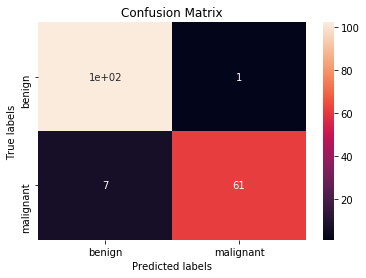

In [29]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

logreg_scaled = LogisticRegression()
logreg_scaled.fit(X_train_scaled, y_train)

y_pred = logreg_scaled.predict(X_test_scaled)
class_report(y_test,y_pred)

### 4.2 KNN Classifier

KNN is a non-parametric model, i.e. it does not make any underlying assumptions on the underlying data distribution. 
Here we use the default value of k=5.

              precision    recall  f1-score   support

           2       0.94      0.99      0.96       103
           4       0.98      0.90      0.94        68

    accuracy                           0.95       171
   macro avg       0.96      0.94      0.95       171
weighted avg       0.95      0.95      0.95       171



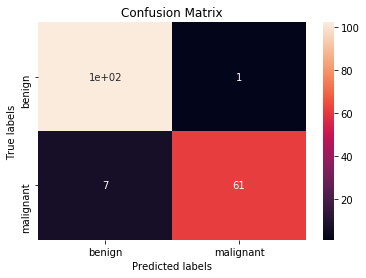

In [31]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)
class_report(y_test,y_pred)

By increasing the value of k from 5 to 11, recall improved from 90% to 91%. 

              precision    recall  f1-score   support

           2       0.94      0.99      0.97       103
           4       0.98      0.91      0.95        68

    accuracy                           0.96       171
   macro avg       0.96      0.95      0.96       171
weighted avg       0.96      0.96      0.96       171



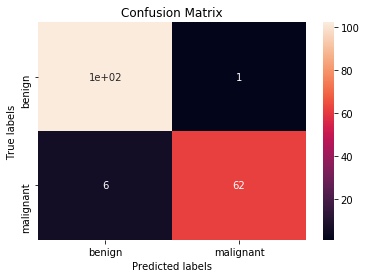

In [39]:
knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)
class_report(y_test,y_pred)

### 4.3  Random Forest Classifier

Here we want to use an bagging ensemble model which subsamples the data with replacement.

              precision    recall  f1-score   support

           2       0.93      0.99      0.96       103
           4       0.98      0.88      0.93        68

    accuracy                           0.95       171
   macro avg       0.96      0.94      0.94       171
weighted avg       0.95      0.95      0.95       171



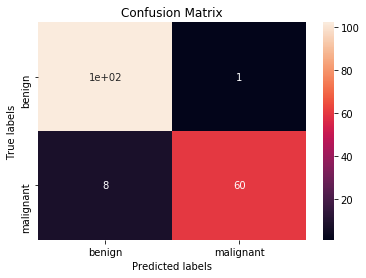

In [34]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)
class_report(y_test,y_pred)

The Random Forest classifier has feature importances after fitting. We can visualize these by sorting the feature importances from the most important to the least important. Here we see that the features of 'Uniformity of Cell Size' and 'Uniformity of Cell Shape' are the top 2 most important features. 

(-1, 9)

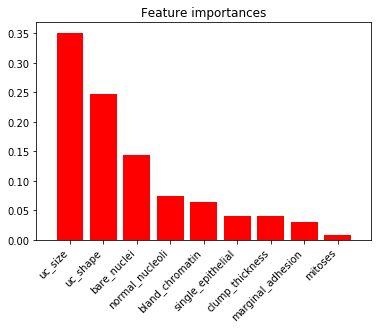

In [40]:
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], color="r", align="center",tick_label = X_train.columns.values)
# plt.xticks(range(X.shape[1]), indices)

plt.xticks(range(X_train.shape[1]), X_train.columns.values[indices],rotation=45,horizontalalignment='right')
plt.xlim([-1, X_train.shape[1]])

## 5. Conclusion

### 5.1 Data
Given a set of biopsied breast cell data, we want to model whether a cell is benign or cancerous. First we cleaned up the data set, and looked at the distribution and correlations of the feautures. Then we fit the data with some common classifier models. Since the classes are imbalanced, we should be using f1-score instead of accuracy to evaluate our models. We select the models starting from the simplest ones. 

### 5.2 Takeaway
Another key point is to understand the application of this data exercise. We would like stakeholder to use the insights from our model, i.e. doctors and physicians. What they care about for cancer prognosis (screening) is to have minimal false negatives. They do not want actual cancer patients to slip through the cracks. So a very key metric we use in this case is recall.

### 5.3 Model selection
To conclude, the KNN classifier with k=11 neighbours outperforms all other classifiers in this exercise, achieving 91% recall. Given more time, I would further explore more complex models that could further increase the recall rate.